In [163]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

In [334]:
files = glob("yosemite_data/*")
data = pd.DataFrame()
for x in files:
    data = data.append(pd.DataFrame(np.loadtxt(x, usecols = (1,2,8))))

In [89]:
data.head()

,0,1,2
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


In [335]:
day = np.asarray(data[0])
time = np.asarray(data[1])
temp = np.asarray(data[2])

In [91]:
print(day, time)

[20110101. 20110101. 20110101. ... 20161231. 20161231. 20170101.] [   5.   10.   15. ... 2350. 2355.    0.]


In [336]:
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
nday = []

for x in day:
    new = str(x)
    y = int(new[:4])
    m = int(new[4:6])
    d = int(new[6:8])
    n = sum(days_in_month[:(m-1)], d)
    if y%4 == 0:
        n+=1
    nday.append(n)

In [337]:
nmin = []
for x in time:
    new = str(int(x))
    if len(new)==4:
        h = int(new[:2])
        m = int(new[2:])
        n = h*60 + m
    elif len(new)==3:
        h = int(new[:1])
        m = int(new[1:])
    else:
        h = 0
        m = int(x)
    n = h*60 + m
    nmin.append(n)

In [339]:
nones = []
for x in range(len(temp)):
    if temp[x] == -9999:
        nones.append(x)
temp[nones] = None

In [340]:
print(len(nmin), len(nday),len(temp))
nmin1 = np.delete(nmin, nones)
nday1 = np.delete(nday, nones)
temp1 = np.delete(temp, nones)
print(len(nmin1), len(nday1), len(temp1))

631296 631296 631296
630854 630854 630854


In [318]:
#the expression for a simple gaussian radial basis function
def radial_basis_func(data, center, w):
    rdata = []
    for i in range(len(data)):
        rdata.append(np.exp(-(w)*(data[i]-center)**2))
    return(rdata)

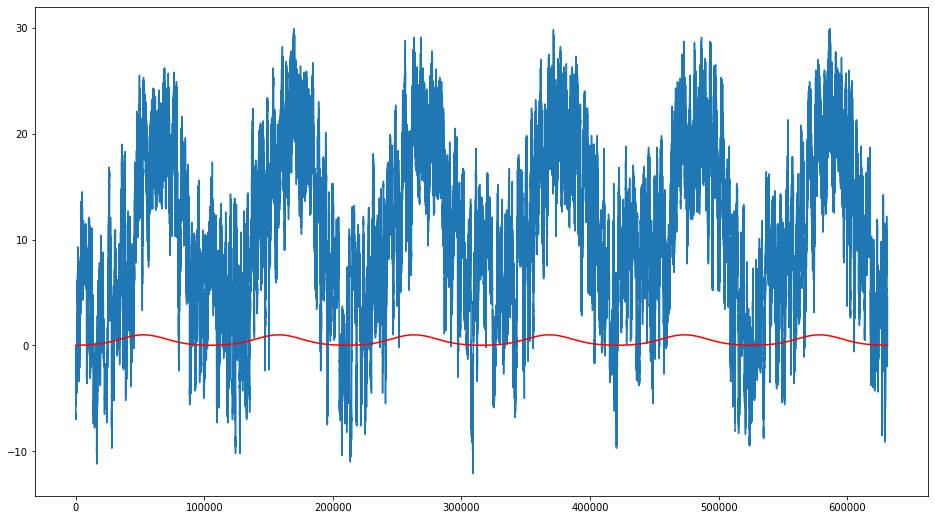

In [317]:
#data centered around the day of the year
cday = radial_basis_func(nday, np.mean(nday),(1/7500))
plt.figure(figsize=(16,9))
plt.plot(temp1)
plt.plot(cday, color='r')

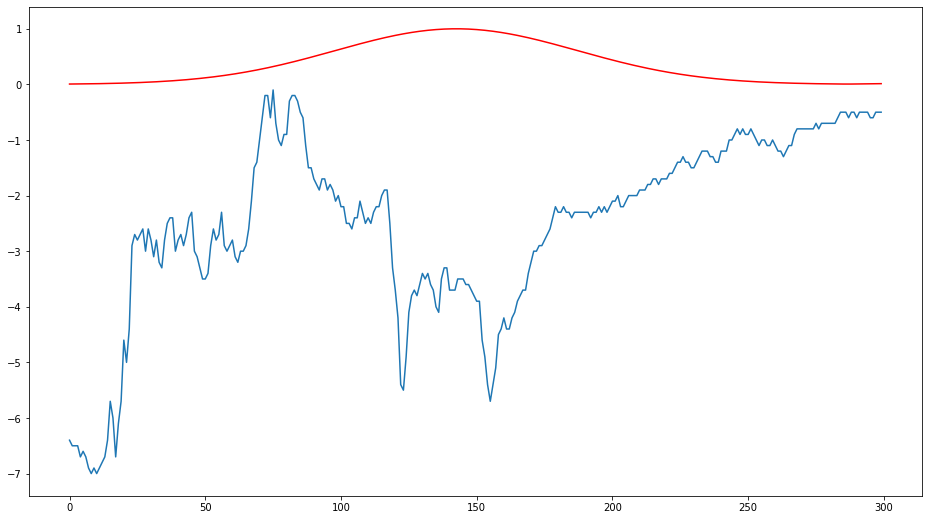

In [311]:
#data centered around the time of day
cmin = radial_basis_func(nmin, np.mean(nmin),(1/100000))
plt.figure(figsize=(16,9))
plt.plot(temp1[:300])
plt.plot(cmin[:300], color='r')

In [342]:
#center the data around the time of the day with many centers
aw = np.linspace(min(nmin1), max(nmin1), 20)
a = rbf_kernel(nmin1.reshape(-1,1), aw.reshape(-1,1), gamma = 1/9000)
a.shape

(630854, 20)

In [406]:
#fit a model predicting temp based on time of day
m1 = Ridge(alpha = 0.001, fit_intercept = False)
m1.fit(a[:600000], temp1[:600000])
print("Score on data",m1.score(a[600000:], temp1[600000:]))

Score on data -0.0762527816054912


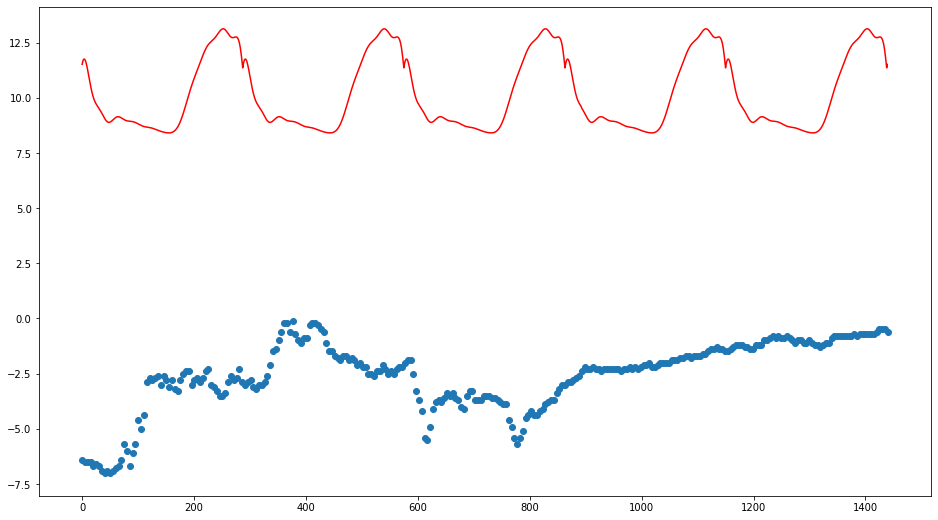

In [344]:
#temp predicted by time of day
plt.figure(figsize=(16,9))
plt.plot(m1.predict(a)[:1440], color = 'r')
plt.scatter(np.linspace(0, 1440, 288), temp1[:288])

In [345]:
#center the data around the day of the year
bw = np.linspace(min(nday1), max(nday1), 20)
b = rbf_kernel(nday1.reshape(-1,1), bw.reshape(-1,1), gamma = 1/75000)
b.shape

(630854, 20)

In [405]:
#fit a model predicting temp based on day of year
m2 = Ridge(alpha = 0.001, fit_intercept = False)
m2.fit(b[:600000], temp1[:600000])
print("Score on data",m2.score(b[600000:], temp1[600000:]))

Score on data 0.4057443080582106


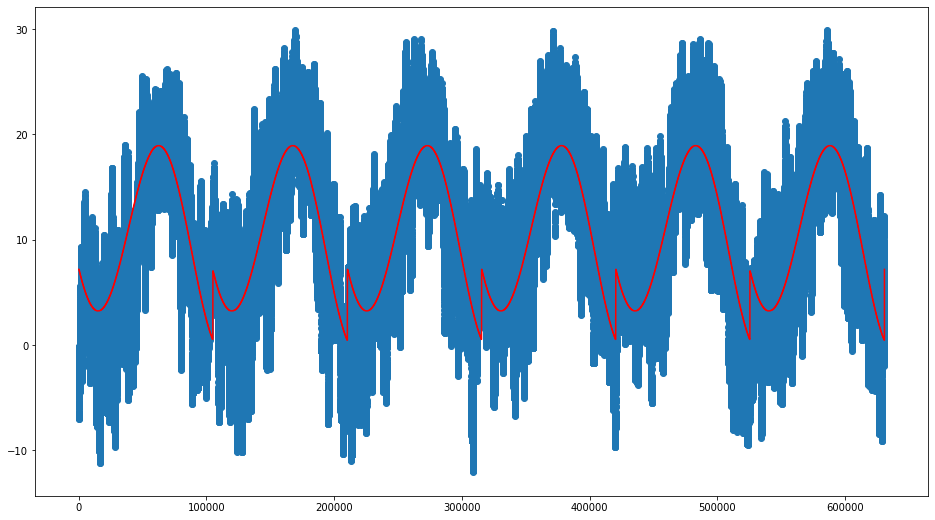

In [347]:
#temp predicted by day of year
plt.figure(figsize=(16,9))
plt.plot(m2.predict(b), color = 'r')
plt.scatter(np.linspace(0,len(temp1), len(temp1)), temp1)

In [401]:
nboth = np.array([nmin1,nday1]).transpose()
w = np.array([aw, bw]).transpose()
sig = 19000

c = rbf_kernel(nboth, w, gamma = 1/sig)

In [404]:
#training with the full model
model = Ridge(alpha = 0.01, fit_intercept = False)
model.fit(c[:600000], temp1[:600000])
print("Score on data", model.score(c[600000:], temp1[600000:]))

Score on data -0.624011713846703


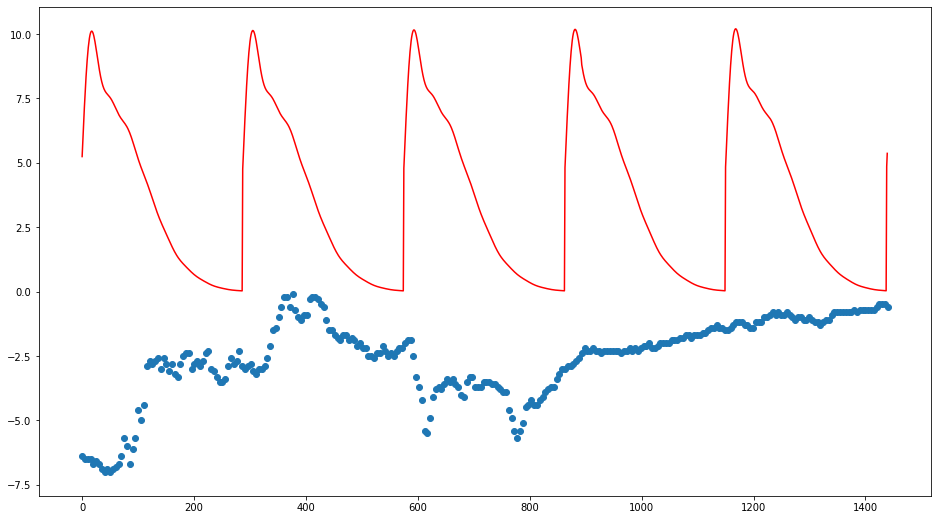

In [403]:
#full model
plt.figure(figsize=(16,9))
plt.plot(model.predict(c)[:1440], color = 'r')
plt.scatter(np.linspace(0, 1440, 288), temp1[:288])

### Conclusions

In this assignment we have a data that is dependent on different cycles. We know that temperature fluctuates depending on the time of day and the time of year, so we can use a radial basis function to capture the typical movements in a model. Then using a linear set of weights we can build a linear parameter model to predict temperatures using our radial basis function. 

We evaluated the performance using R^2 values, which explain how the variance in the temperature is described by the variance in the time of day or time of year (depending on which score you are looking at). From the results here we see that yearly fluctuations explain more than the daily ones, however the combined model outperforms both of them. 

